In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
from PIL import Image
import cv2

Connect to the shared folder in Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

def load_csv_from_drive(file_path):

    # Check if the file exists before attempting to load
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        print("CSV file loaded successfully!")
        print(df.head()) # Display the first few rows of the dataframe
    else:
        print(f"File not found at: {file_path}")
        print("Please ensure the folder and file names are correct and Google Drive is mounted.")
    return df

Mounted at /content/drive


In [115]:
# Working Folders:
folder_source = '/content/drive/My Drive/DATASCI 281/ISIC_2019_cleaned/'
folder_target = '/content/drive/My Drive/DATASCI 281/ISIC_2019_cropped/'
working_folder = '/content/drive/My Drive/DATASCI 281/'
file_metadata_source = 'resampled_metadata_with_size.csv'
file_metadata_target = 'resampled_metadata_cropped.csv'

In [116]:
# Load the metadata file
metadata_df = load_csv_from_drive(working_folder + file_metadata_source)
metadata_new = metadata_df.copy()

CSV file loaded successfully!
                                image category augmentation_method   width  \
0  ISIC_0068778_preprocessed_rot0.jpg      MEL                rot0  1024.0   
1  ISIC_0058285_preprocessed_rot0.jpg      MEL                rot0  1024.0   
2  ISIC_0073194_preprocessed_rot0.jpg      MEL                rot0  1024.0   
3  ISIC_0058003_preprocessed_rot0.jpg      MEL                rot0  1024.0   
4  ISIC_0070105_preprocessed_rot0.jpg      MEL                rot0  1024.0   

   height  
0  1024.0  
1  1024.0  
2  1024.0  
3  1024.0  
4  1024.0  


In [117]:
def detect_circular_vignette(image_path, display=False, brightness_threshold=0.95):
    """
    Detect and mask circular vignettes based on radial brightness profile, and
    crops the image to the square incvribed in the circle of the vignette.

    Returns:
        The cropped image, and its dimensions.
    """
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # color correction for the gray image
    # gray = cv2.equalizeHist(gray)

    # Determine hight, width, and center
    h, w = gray.shape
    center = (w // 2, h // 2)

    # Compute distance from the center for each pixel
    Y, X = np.indices((h, w))
    distance = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    # Build radial brightness profile
    max_distance = np.max(distance)
    num_bins = 100
    radial_means = np.zeros(num_bins)
    bin_edges = np.linspace(0, max_distance, num_bins + 1)

    for i in range(num_bins):
        mask = (distance >= bin_edges[i]) & (distance < bin_edges[i+1])
        if np.any(mask):
            radial_means[i] = np.mean(gray[mask])

    # Normalize radial profile
    # radial_means /= np.max(radial_means)

    # Detect the radius where brightness drops below the threshold
    valid_bins = np.where(radial_means > brightness_threshold)[0]
    if len(valid_bins) == 100:
        img2, h2, w2 =  img, w, h
    elif len(valid_bins) == 0:
        img2, h2, w2 =  img, w, h
    elif valid_bins[-1] == 99:
        img2, h2, w2 =  img, w, h
    else:
        valid_radius = bin_edges[valid_bins[-1]]
        h2, w2 = round(valid_radius * np.sqrt(2)), round(valid_radius * np.sqrt(2))
        img2 = cv2.getRectSubPix(img, (w2, h2), center)


    if display:
        fig, ax = plt.subplots(1,3,figsize=(20, 5))

        ax[0].imshow(img); ax[0].set_title(f"Original Image w:{img.shape}"); ax[0].axis('off')
        ax[1].plot(radial_means); ax[1].set_title('Radial Brightness Profile')
        ax[1].axhline(y=brightness_threshold, color='r', linestyle='--')
        ax[2].imshow(img2);  ax[2].set_title(f'Square w:{img2.shape}'); ax[2].axis('off')

        plt.show()

    return img2, w2, h2

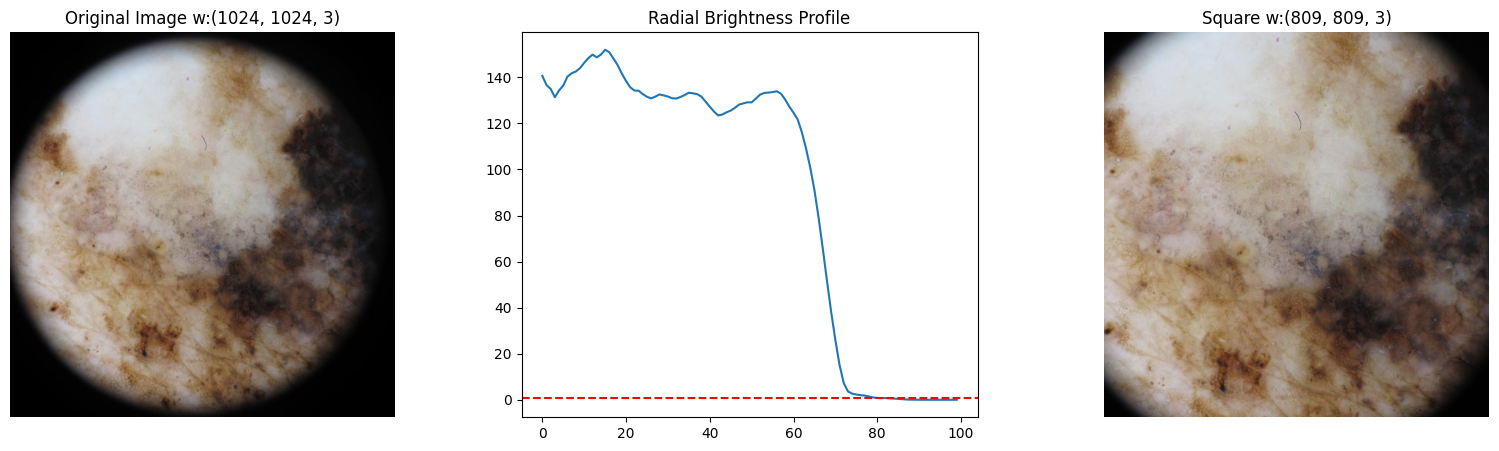

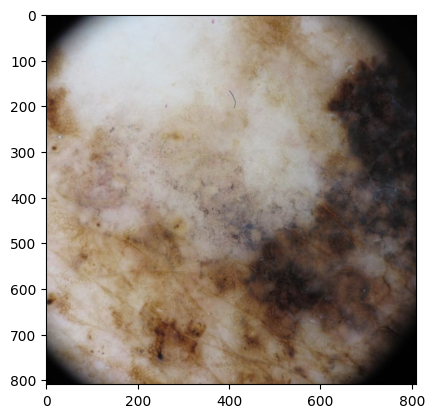

In [7]:
img_array, h , w = detect_circular_vignette(folder_source + metadata_df.loc[10,"image"], brightness_threshold=.8, display = True)

In [ ]:
# Crop and Add the new dimensions to the metadata file (this process takes 2 hrs)
for idx in tqdm(metadata_df.index, desc="Processing Files"):
    cropped_img, h , w = detect_circular_vignette(folder_source + metadata_df.loc[idx,"image"], brightness_threshold=100)
    cropped_img = Image.fromarray(cropped_img)
    metadata_new.loc[idx, 'cropped_width'] = w
    metadata_new.loc[idx, 'cropped_height'] = h
    cropped_img.save(folder_target + metadata_df.loc[idx, 'image'])
metadata_new.to_csv(working_folder + file_metadata_target, index=False)


In [119]:
# review
metadata_new = load_csv_from_drive(working_folder + file_metadata_target)


CSV file loaded successfully!
                                image category augmentation_method   width  \
0  ISIC_0068778_preprocessed_rot0.jpg      MEL                rot0  1024.0   
1  ISIC_0058285_preprocessed_rot0.jpg      MEL                rot0  1024.0   
2  ISIC_0073194_preprocessed_rot0.jpg      MEL                rot0  1024.0   
3  ISIC_0058003_preprocessed_rot0.jpg      MEL                rot0  1024.0   
4  ISIC_0070105_preprocessed_rot0.jpg      MEL                rot0  1024.0   

   height  cropped_width  cropped_height  
0  1024.0         1024.0          1024.0  
1  1024.0         1024.0          1024.0  
2  1024.0          614.0           614.0  
3  1024.0         1024.0          1024.0  
4  1024.0          707.0           707.0  


<Axes: >

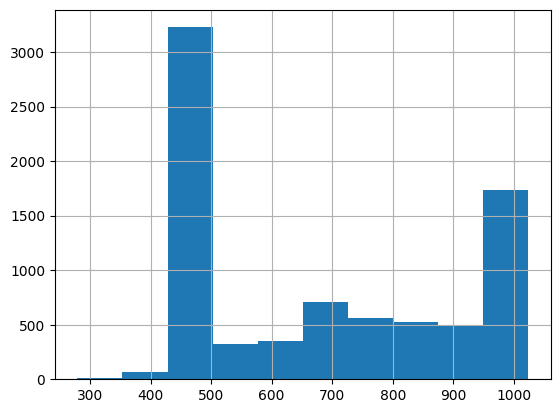

In [120]:
metadata_new['cropped_height'].hist()

<Axes: >

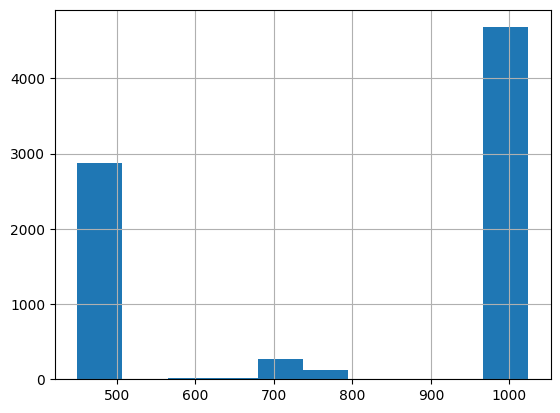

In [121]:
metadata_new['height'].hist()

In [122]:
metadata_new['cropped_height'].value_counts().sort_index()

cropped_height
279.0        1
302.0        1
328.0        2
338.0        1
342.0        1
          ... 
973.0       45
983.0       49
993.0       49
1004.0      49
1024.0    1467
Name: count, Length: 119, dtype: int64

In [123]:
metadata_new[metadata_new['cropped_height']<450]

image category augmentation_method  \
17     ISIC_0032844_preprocessed_rot0.jpg      MEL                rot0   
37     ISIC_0064406_preprocessed_rot0.jpg      MEL                rot0   
77     ISIC_0033317_preprocessed_rot0.jpg      MEL                rot0   
119    ISIC_0025904_preprocessed_rot0.jpg      MEL                rot0   
138    ISIC_0033967_preprocessed_rot0.jpg      MEL                rot0   
...                                   ...      ...                 ...   
7887  ISIC_0070772_preprocessed_rot90.jpg      SCC               rot90   
7894  ISIC_0025319_preprocessed_rot90.jpg      SCC               rot90   
7923  ISIC_0060774_preprocessed_rot90.jpg      SCC               rot90   
7970  ISIC_0061016_preprocessed_rot90.jpg      SCC               rot90   
7996  ISIC_0029417_preprocessed_rot90.jpg      SCC               rot90   

       width  height  cropped_width  cropped_height  
17     450.0   450.0          432.0           432.0  
37    1024.0  1024.0          440.0           440.0  
77     450.0   450.0          387.0           387.0  
119    450.0   450.0          432.0           432.0  
138    450.0   450.0          428.0           428.0  
...      ...     ...            ...             ...  
7887  1024.0  1024.0          430.0           430.0  
7894   450.0   450.0          423.0           423.0  
7923  1024.0  1024.0          440.0           440.0  
7970  1024.0  1024.0          440.0           440.0  
7996   450.0   450.0          405.0           405.0  

[294 rows x 7 columns]

In [124]:
metadata_new['Crop_raio']  = metadata_new['cropped_height']/metadata_new['height']

In [128]:
metadata_new['Crop_raio'].isna().sum()

np.int64(0)

In [126]:
small_set = metadata_new[metadata_new['Crop_raio'] < .75].sort_values(by='Crop_raio', ascending=True).reset_index()

In [129]:
small_set.shape

(1718, 9)

In [91]:
def review(img_idx, folder_source, folder_target, metadata_df, brightness_threshold):
    fig, ax = plt.subplots(1,2,figsize=(15, 5))
    img = Image.open(folder_source + metadata_df.loc[img_idx,"image"])
    ax[0].imshow(img); ax[0].set_title('Original Image')
    img = Image.open(folder_target + metadata_df.loc[img_idx,"image"])
    ax[1].imshow(img);  ax[1].set_title('Final')
    plt.show()
    img_array, h , w = detect_circular_vignette(folder_source + metadata_df.loc[img_idx,"image"], display = True, brightness_threshold = brightness_threshold)
    print(metadata_df.loc[img_idx,"image"])

    print("size cropped:",metadata_df.loc[img_idx,"width"])
    print("Improved size:",h)

def flagger(idx_start, img_num, metadata_df, folder_source, folder_target, brightness_threshold):

    fig, ax = plt.subplots(img_num, 2, figsize=(6, 4*img_num))

    for img_idx in range(idx_start, idx_start + img_num):
        image_name = metadata_df.loc[img_idx, "image"]
        source_path = os.path.join(folder_source, image_name)
        target_path = os.path.join(folder_target, image_name)

        # Display the original and final images
        try:
            img_original = Image.open(source_path)
            img_processed = Image.open(target_path)
        except:
            print(f"Error opening image: {image_name}")
            continue

        ax[img_idx-idx_start, 0].imshow(img_original)
        ax[img_idx-idx_start, 0].set_title(image_name)
        ax[img_idx-idx_start, 0].axis('off')

        ax[img_idx-idx_start, 1].imshow(img_processed)
        ax[img_idx-idx_start, 1].set_title('Final ' + metadata_df.loc[img_idx, 'cropped_height'].astype(str))
        ax[img_idx-idx_start, 1].axis('off')


In [130]:
metadata_new = flagger(600, 101, small_set, folder_source, folder_target, 100)
# flagged:
#ISIC_0065790_preprocessed_rot0.jpg
#ISIC_0064406_preprocessed_rot0.jpg
#ISIC_0071315_preprocessed_rot0.jpg
#ISIC_0056611_preprocessed_rot0.jpg
#ISIC_0061194_preprocessed_rot0.jpg
#ISIC_0061194_preprocessed_rot0.jpg


Output hidden; open in https://colab.research.google.com to view.

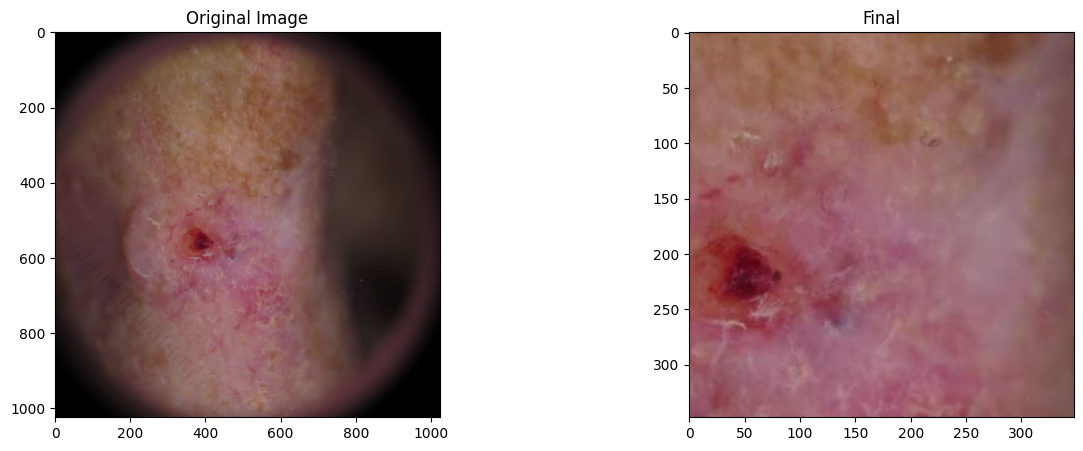

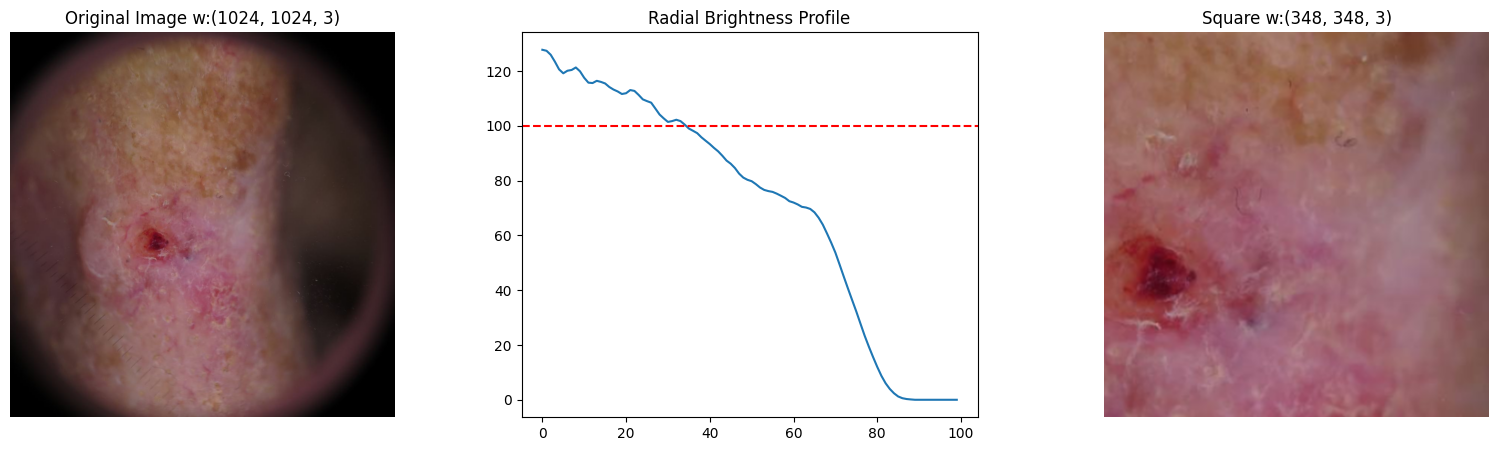

ISIC_0065790_preprocessed_rot0.jpg
size cropped: 1024.0
Improved size: 348


In [38]:
review(0, folder_source, folder_target, small_set, 100)

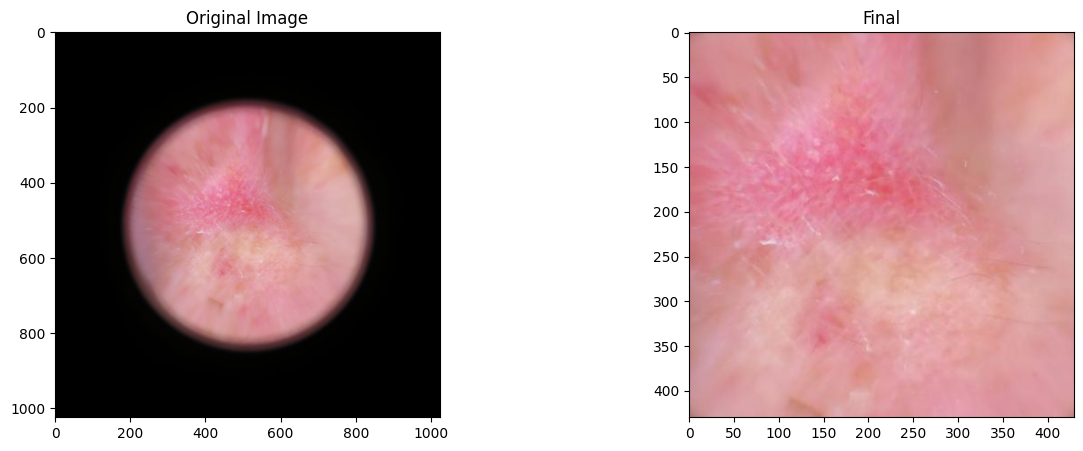

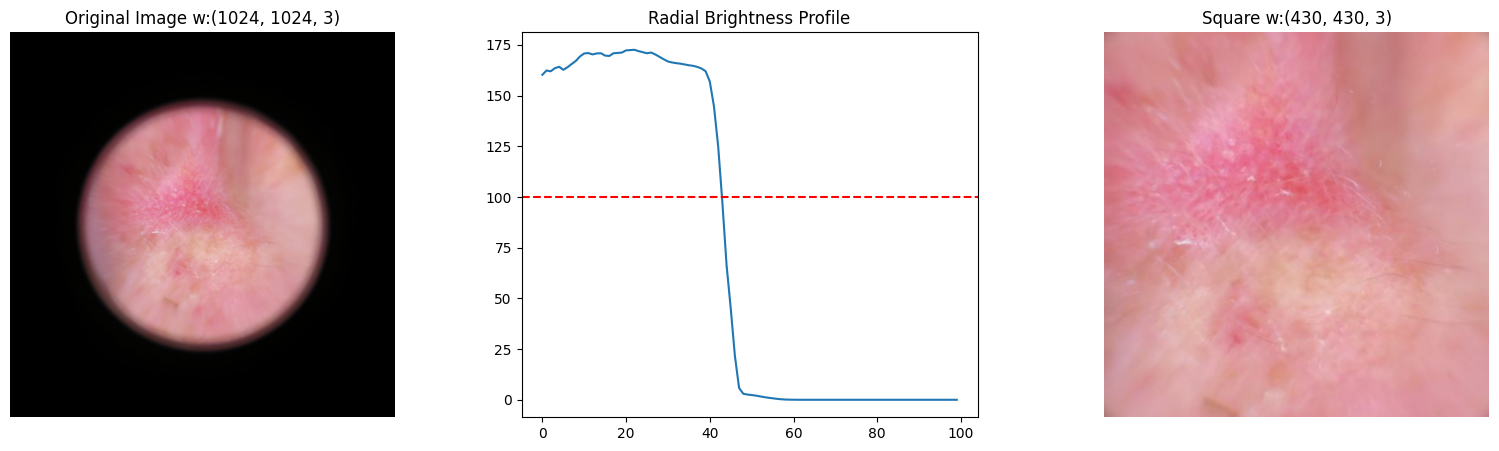

ISIC_0070772_preprocessed_rot0.jpg
size cropped: 1024.0
Improved size: 430


In [77]:
review(26, folder_source, folder_target, small_set, 100)

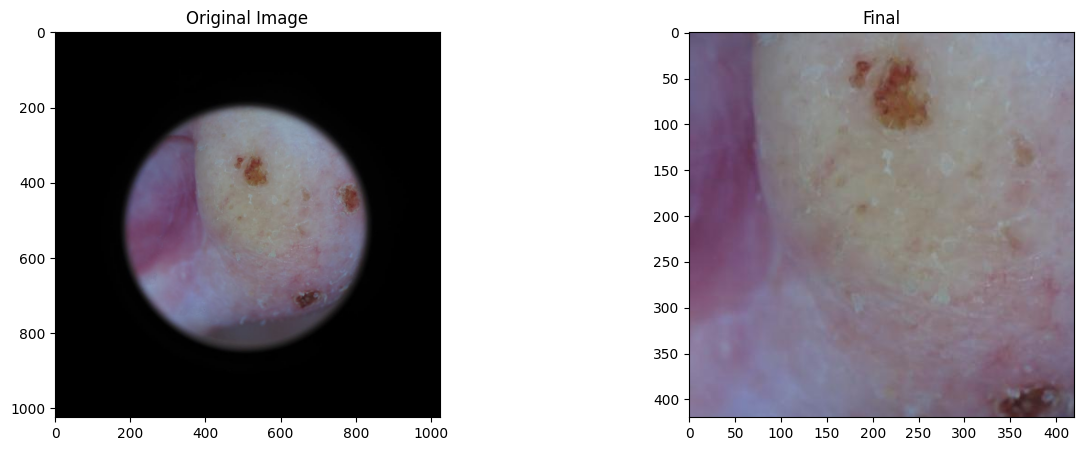

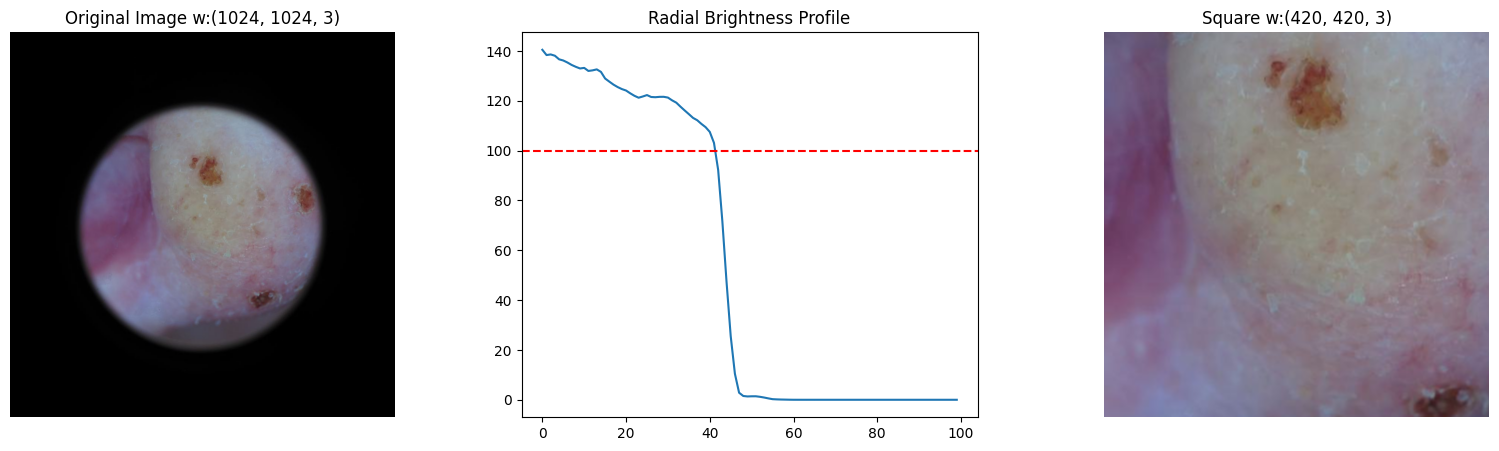

ISIC_0070975_preprocessed_rot0.jpg
size cropped: 1024.0
Improved size: 420


In [40]:
review(3, folder_source, folder_target, small_set, 100)

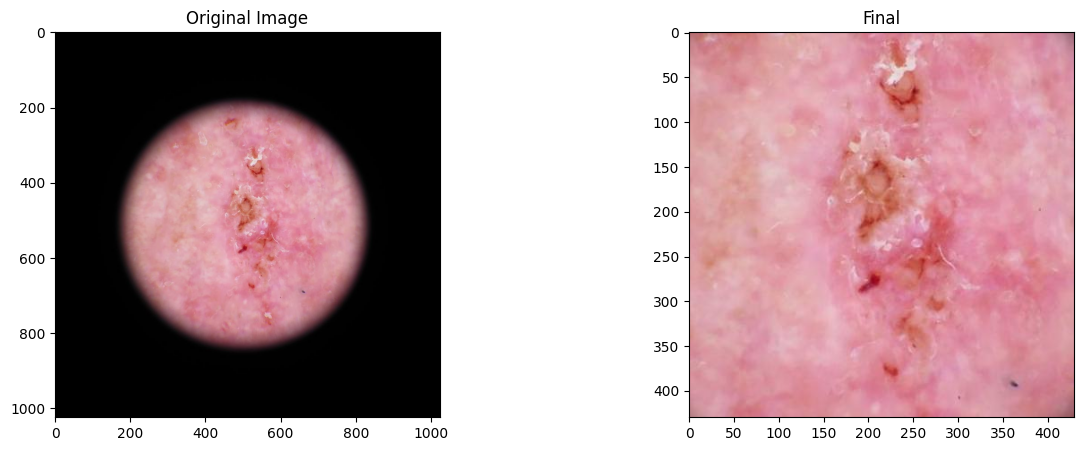

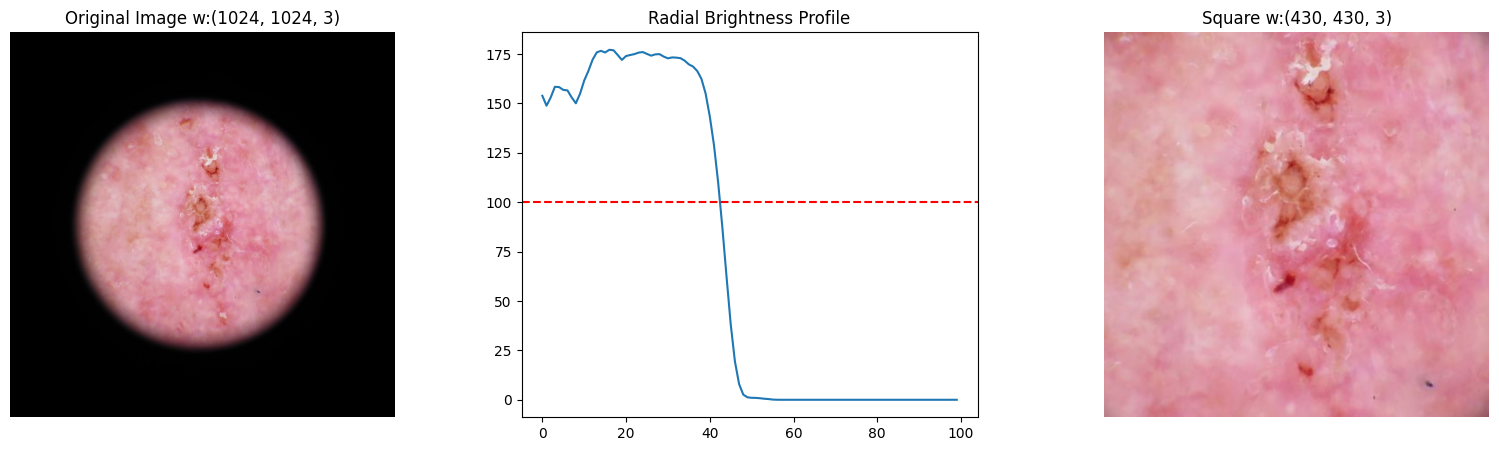

ISIC_0066062_preprocessed_rot0.jpg
size cropped: 1024.0
Improved size: 430


In [41]:
review(4, folder_source, folder_target, small_set, 100)

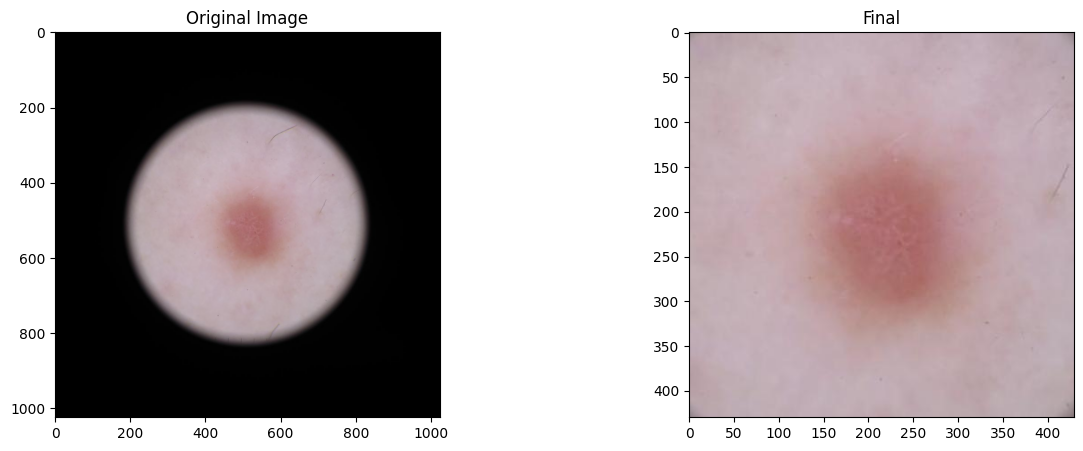

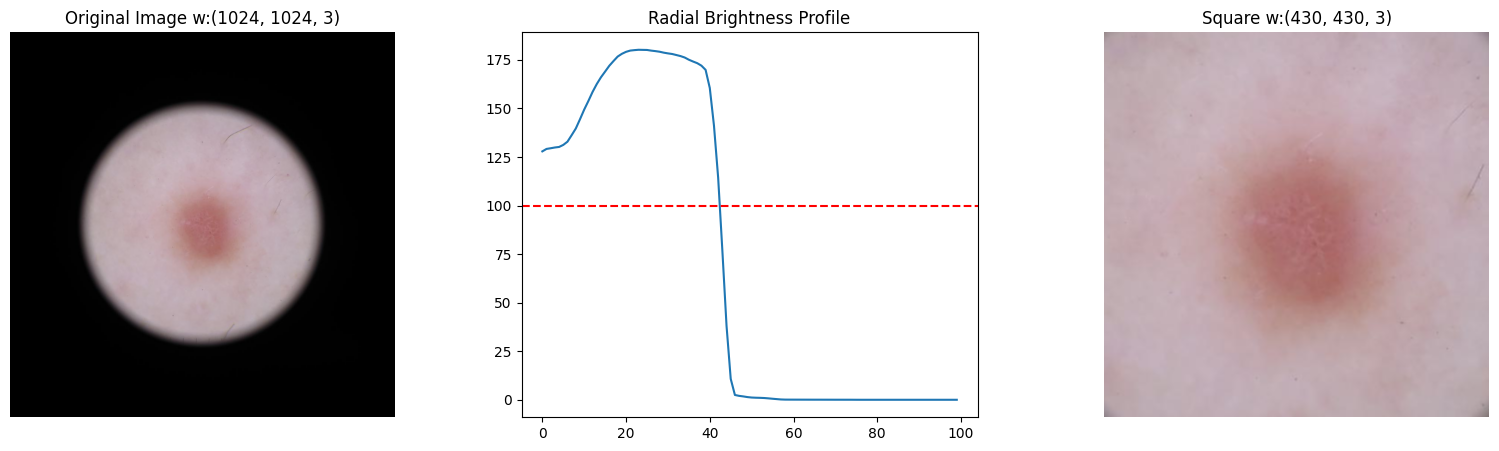

ISIC_0056996_preprocessed_rot180.jpg
size cropped: 1024.0
Improved size: 430


In [42]:
review(5, folder_source, folder_target, small_set, 100)

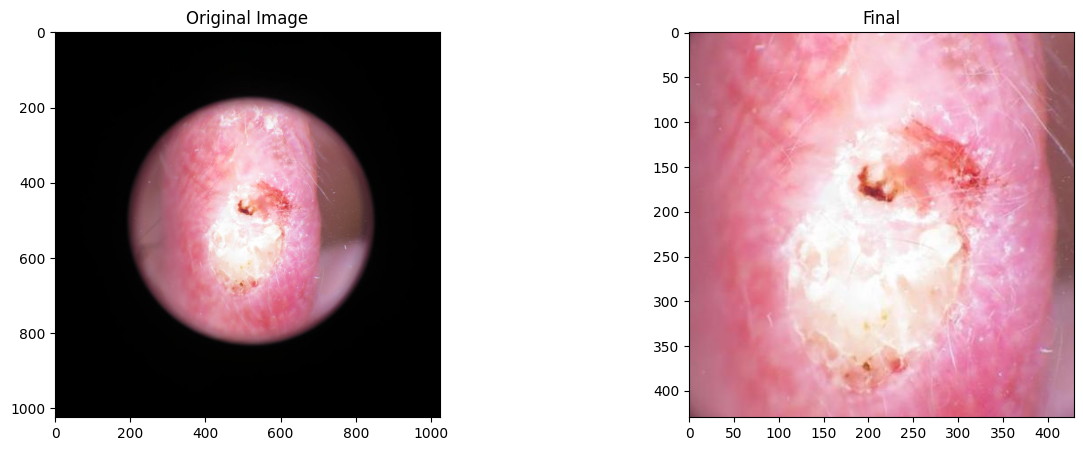

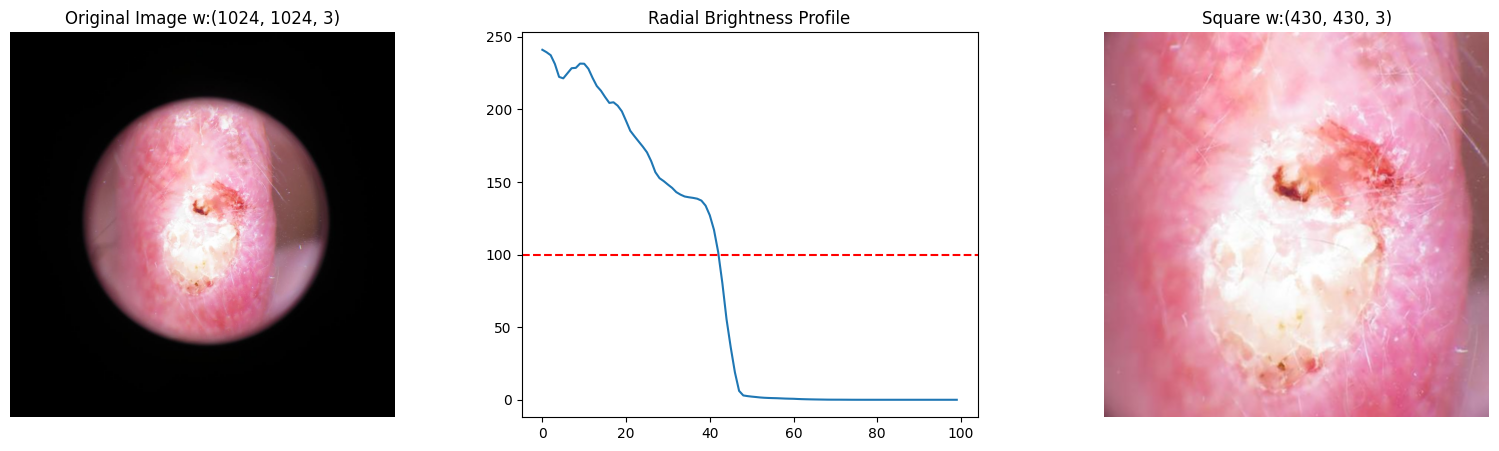

ISIC_0060800_preprocessed_rot90.jpg
size cropped: 1024.0
Improved size: 430


In [43]:
review(6, folder_source, folder_target, small_set, 100)

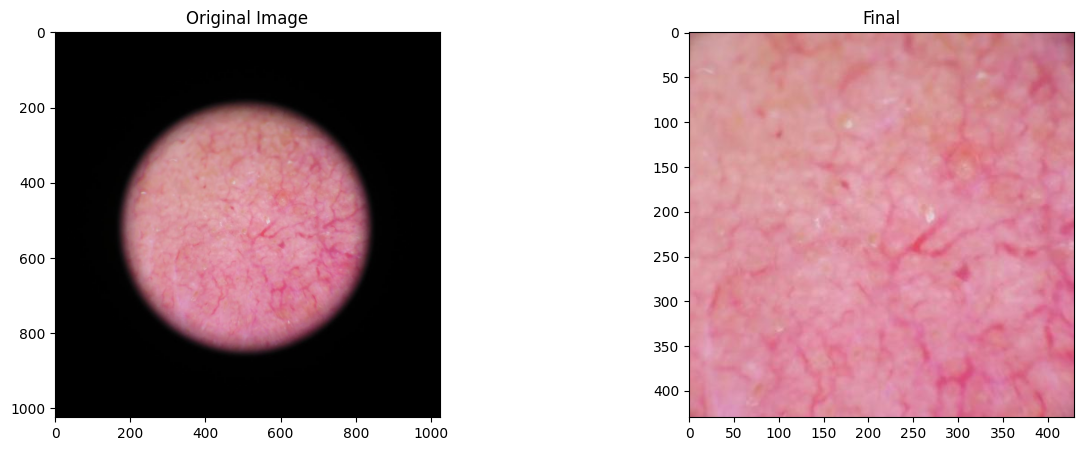

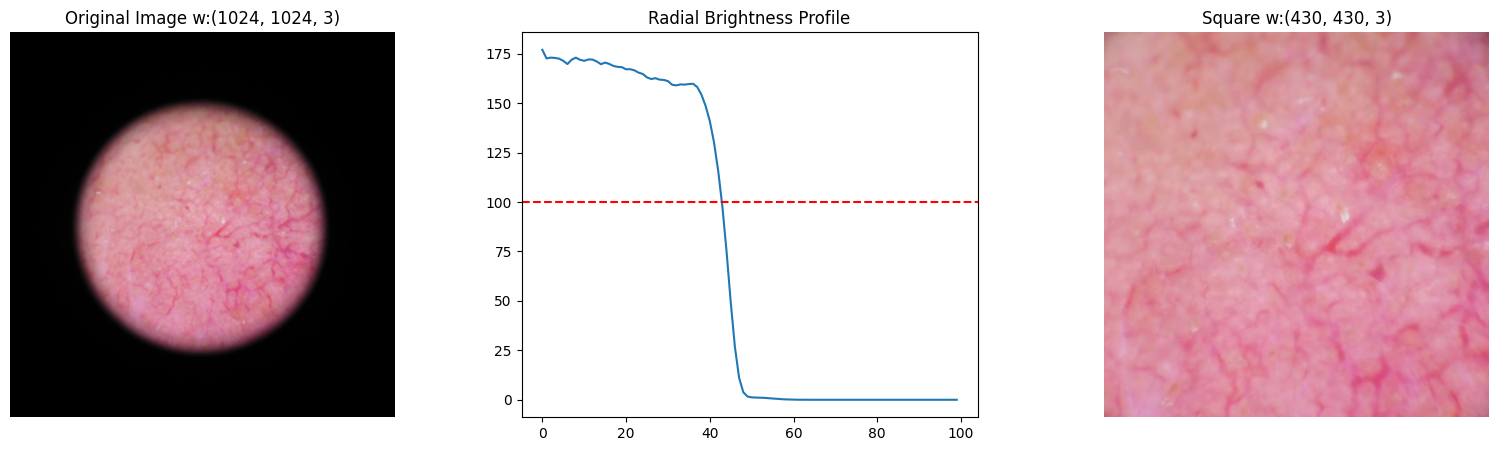

ISIC_0064583_preprocessed_rot0.jpg
size cropped: 1024.0
Improved size: 430


In [44]:
review(7, folder_source, folder_target, small_set, 100)

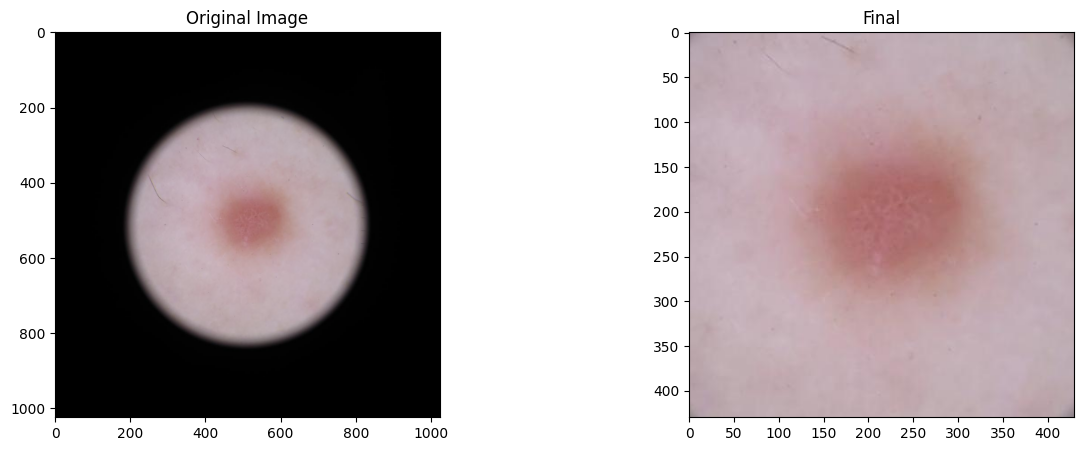

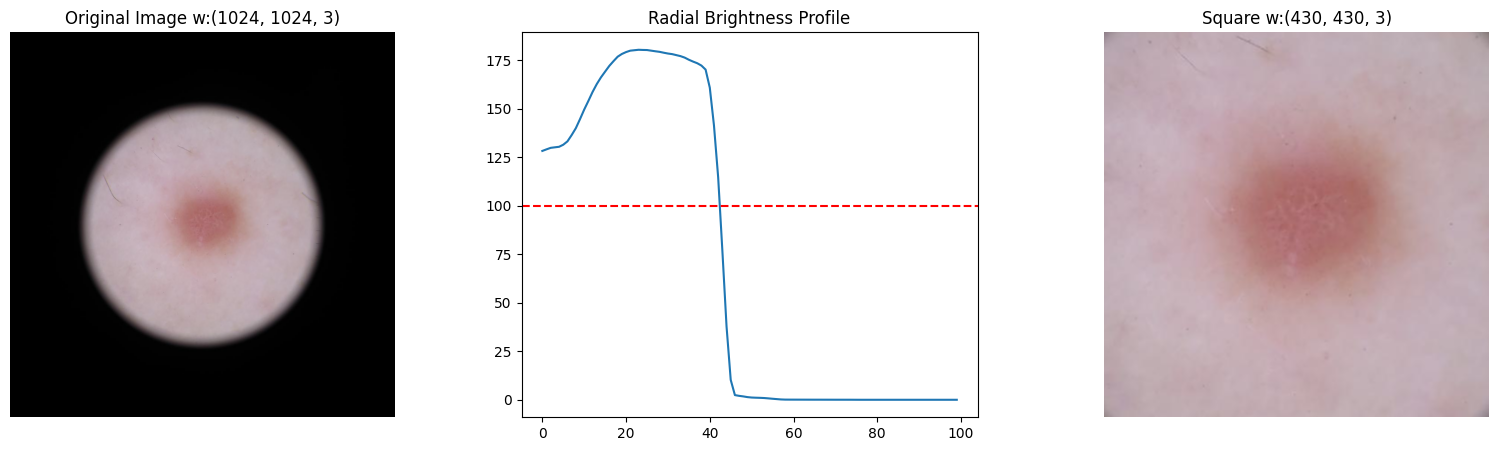

ISIC_0056996_preprocessed_rot270.jpg
size cropped: 1024.0
Improved size: 430


In [45]:
review(8, folder_source, folder_target, small_set, 100)

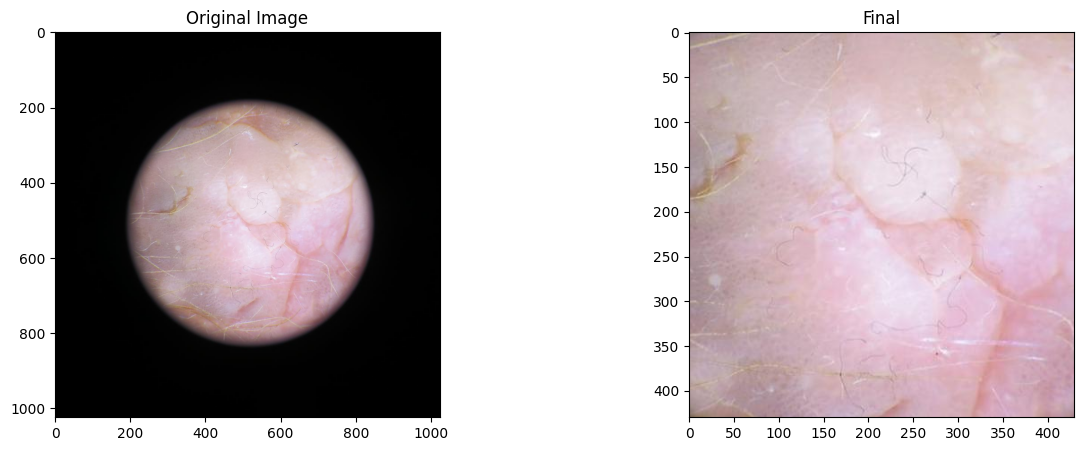

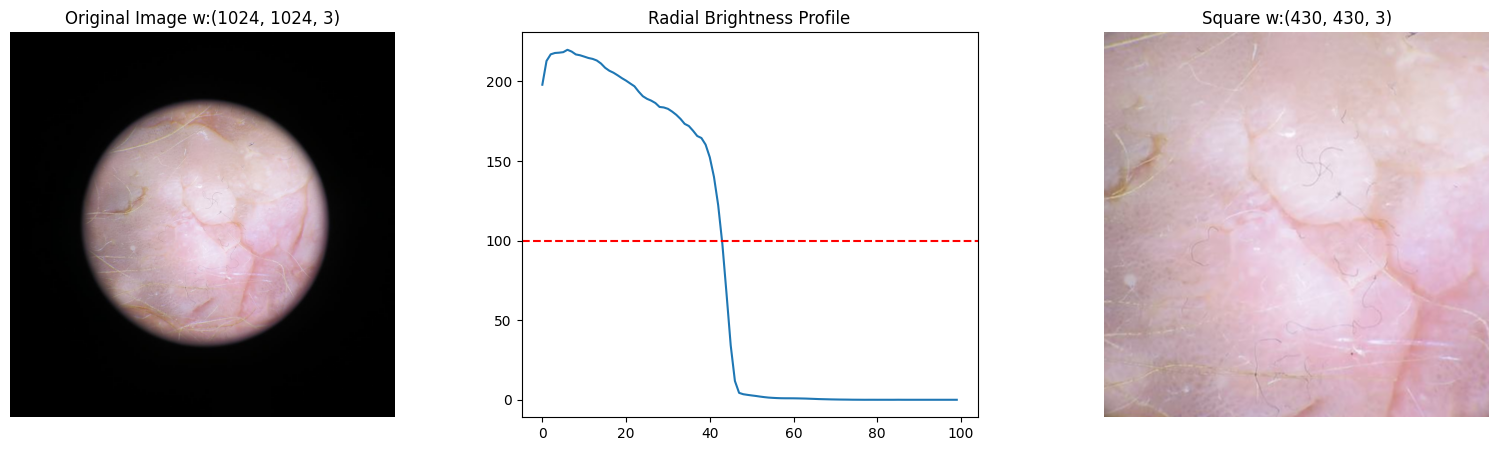

ISIC_0070350_preprocessed_rot0.jpg
size cropped: 1024.0
Improved size: 430


In [46]:
review(9, folder_source, folder_target, small_set, 100)